**Deep Learning**

HW2 - Problem 1 - Fashion-MNIST (120 pts)

Full Name: **Nima Kelidari**

Student Number: **98108124**

# **(آ) اضافه کردن دیتاست و نمایش آن**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 0s 0us/step


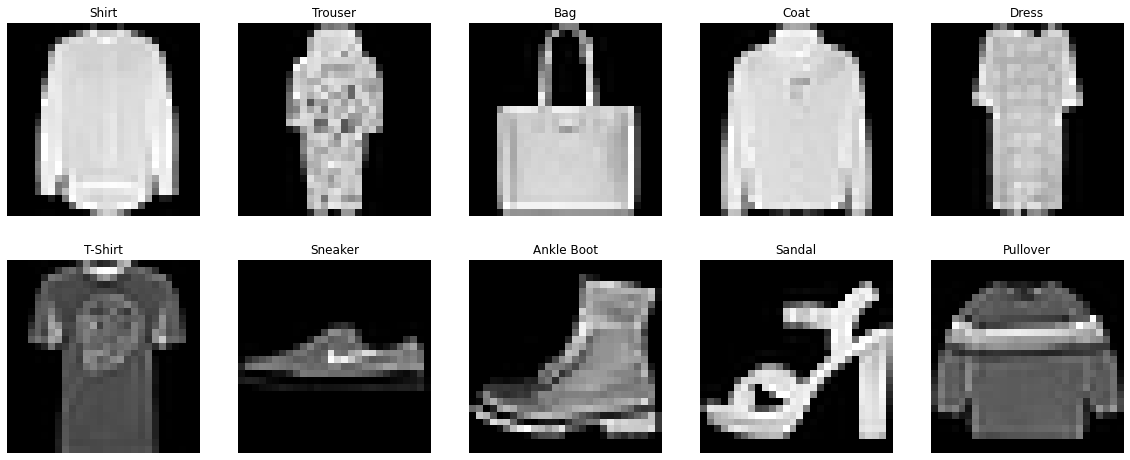

In [3]:
from tensorflow.python.ops.array_ops import lower_bound
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(20, 8))
cols, rows = 5, 2
counter = 0
num = len(x_train)
labels = []
while(counter!=10):
    sample_idx = np.random.randint(0,num)
    img, label = x_train[sample_idx],y_train[sample_idx]
    if not(label in labels):
      counter+=1
      figure.add_subplot(rows, cols, counter)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
      labels.append(label)
plt.show()

# **(ب) پیاده سازی شبکه**

Defenite essential functions

In [4]:
def shuffle_rows(data):
  data = np.array(data)
  np.random.shuffle(data)
  return data

def shuffle(input,target,onehot):
  idx = [i for i in range(input.shape[1])]
  np.random.shuffle(idx)
  input = input[:,idx]
  target = target[idx]
  onehot = onehot[:,idx]
  return input,target,onehot

def get_predictions(AL):
  return np.argmax(AL, axis=0)
  
def get_accuracy(Y_hat, Y):
  return np.sum(Y_hat == Y) / Y.shape[0]

def printing(title,acc,loss):
  print(title,'Acc:',int(10000*acc)/100,'% -- Loss:',int(1000*loss)/1000)

def normalize_pixels(data):
  return data/255.

def one_hot(y):
        table = np.zeros((y.shape[0], 10))
        for i in range(y.shape[0]):
            table[i][int(y[i])] = 1 
        return table.T

def chenge_to_numpy(x,y):
  return np.array(x.reshape(-1,28*28)).T/255,np.array(y.reshape(-1,))


Initialise Neural Network

In [5]:
def init_params(layers_dims):
  params = {}
  for layer in range(1,len(layers_dims)):
    params['W'+str(layer)] = np.random.randn(layers_dims[layer], layers_dims[layer-1]) * np.sqrt(1. / layers_dims[layer])
    params['b'+str(layer)] = np.random.randn(layers_dims[layer],1) * np.sqrt(1. / layers_dims[layer])
    
  return params






Activation functions

In [6]:
  
def relu(Z):
  return np.maximum(Z,0)

def softmax(Z):
  A = np.exp(Z) / sum(np.exp(Z))
  return A

def deriv_relu(Z):
  return Z > 0

def deriv_softmax(Z):    
    dZ = np.exp(Z) / sum(np.exp(Z)) * (1. - np.exp(Z) / sum(np.exp(Z)))
    return dZ

Feedforward

In [7]:
def forward_prop(X, params):
  L = len(params) // 2
  activations = {}
  activations['A0'] = X
  for l in range(1,L):
    activations['Z'+str(l)] = np.dot(params['W'+str(l)], activations['A'+str(l-1)]) + params['b'+str(l)]
    activations['A'+str(l)] = relu(activations['Z'+str(l)])
  activations['Z'+str(L)] = np.dot(params['W'+str(L)], activations['A'+str(L-1)]) + params['b'+str(L)]
  activations['A'+str(L)] = softmax(activations['Z'+str(L)])  
  return activations

Back propagation and Update params

In [8]:
def back_prop(activations, params, Y,one_hot_Y):
  L = len(params) // 2  
  m = one_hot_Y.shape[1]
  derivatives = {}
  grads = {}
  derivatives['dZ'+str(L)] = (activations['A'+str(L)] - one_hot_Y)
  grads['dW'+str(L)] = 1 / m * np.dot(derivatives['dZ'+str(L)], activations['A'+str(L-1)].T)
  grads['db'+str(L)] = 1 / m * np.sum(derivatives['dZ'+str(L)])
  for l in reversed(range(1, L)):
    derivatives['dZ'+str(l)] = np.dot(params['W'+str(l+1)].T, derivatives['dZ'+str(l+1)]) * deriv_relu(activations['Z'+str(l)])
    grads['dW'+str(l)] = 1 / m * np.dot(derivatives['dZ'+str(l)], activations['A'+str(l-1)].T)
    grads['db'+str(l)] = 1 / m * np.sum(derivatives['dZ'+str(l)], axis=1, keepdims=True)
  
  return grads

def update_params(params, grads, alpha):
  L = len(params) // 2
  params_updated = {}
  for l in range(1, L+1):
    params_updated['W'+str(l)] = params['W'+str(l)] - alpha*grads['dW'+str(l)]
    params_updated['b'+str(l)] = params['b'+str(l)] - alpha*grads['db'+str(l)]
  return params_updated

Loss function

In [9]:
def cross_entropy(Y_one_hot, Y_hat, epsilon=1e-12):
  Y_hat = np.clip(Y_hat, epsilon, 1.-epsilon)
  cross_entropy = -np.mean(np.sum(Y_one_hot * np.log(Y_hat), axis=0))
  return cross_entropy

Training function

In [10]:
def Train_model(X,Y, one_hot_Y,X_test,Y_test,Y_test_one_hot, layers_size, max_iter, alpha,batch_size):
  params = init_params(layers_size)
  L = len(params)//2
  accuracies = []
  losses = []
  accuracies_test = []
  losses_test = []
  batch_its = X.shape[1]//batch_size-1 
  from tqdm import tqdm
  for iter in tqdm(range(1,max_iter+1)):
    loss=0
    accuracy=0
    X , Y , one_hot_Y = shuffle(X , Y , one_hot_Y)
    for batch in range(batch_its):
      start = batch*batch_size
      end = (batch+1)*batch_size

      x_b = X[:,start:end]
      y_b = Y[start:end]
      onehot_b = one_hot_Y[:,start:end]

      activations = forward_prop(x_b, params)
      Y_hat = get_predictions(activations['A'+str(L)])
      accuracy += get_accuracy(Y_hat, y_b)
      loss += cross_entropy(onehot_b, activations['A'+str(L)])
      grads = back_prop(activations, params, y_b,onehot_b)
      params = update_params(params, grads, alpha)

    accuracy/=batch_its
    loss/=batch_its
    accuracies.append(accuracy*100)
    losses.append(loss)
    activations = forward_prop(X_test, params)
    Y_hat = get_predictions(activations['A'+str(L)])
    acc_test = get_accuracy(Y_hat, Y_test)
    loss_test = cross_entropy(Y_test_one_hot, activations['A'+str(L)])
    accuracies_test.append(acc_test*100)
    losses_test.append(loss_test)
    
  return params,losses,losses_test,accuracies,accuracies_test

# **(ج) آموزش مدل**

In [11]:
train, train_labels = chenge_to_numpy(x_train, y_train)
test, test_labels = chenge_to_numpy(x_test, y_test)

layers_dims = [784, 500, 200, 100, 10]
batch_size = 64
max_iter = 50
lr = 0.02

params,losses,losses_test,accuracies,accuracies_test = Train_model(train, train_labels,one_hot(train_labels),test, test_labels,one_hot(test_labels), layers_dims, max_iter, lr,batch_size)

100%|██████████| 50/50 [10:34<00:00, 12.69s/it]


# **(د) تست مدل و نمایش نتایج**

Get final test accuracy

In [16]:
activations = forward_prop(test, params)
Y_hat = get_predictions(activations['A4'])
acc_test = get_accuracy(Y_hat, test_labels)
loss_test = cross_entropy(one_hot(test_labels), activations['A4'])
print()
printing('  Final Results on 10000 test dataset  ->',acc_test,loss_test)


  Final Results on 10000 test dataset  -> Acc: 89.54 % -- Loss: 0.36


Plot results

Text(0.5, 0, 'Accuracy')

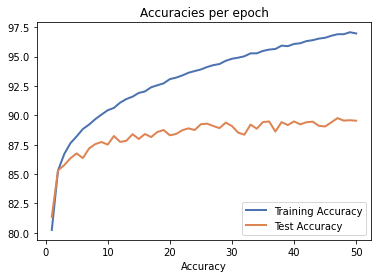

In [19]:
import seaborn as sns
plt.plot(range(1, max_iter+1), accuracies, color=sns.color_palette('deep')[0], linewidth=2, label='Training Accuracy')
plt.plot(range(1, max_iter+1), accuracies_test, color=sns.color_palette('deep')[1], linewidth=2, label='Test Accuracy')
plt.title("Accuracies per epoch")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.xlabel("Accuracy")


Text(0.5, 0, 'Loss')

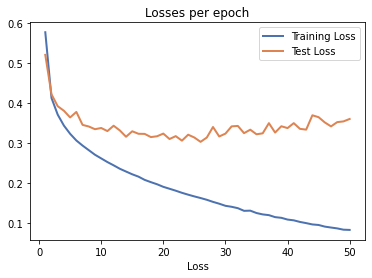

In [21]:
  plt.plot(range(1, max_iter+1), losses, color=sns.color_palette('deep')[0], linewidth=2, label='Training Loss')
  plt.plot(range(1, max_iter+1), losses_test, color=sns.color_palette('deep')[1], linewidth=2, label='Test Loss')
  plt.title("Losses per epoch")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch")
  plt.xlabel("Loss")
  #plt.savefig('images/training_acc_loss_{}.png'.format(layers_size), format='png', dpi=1200)

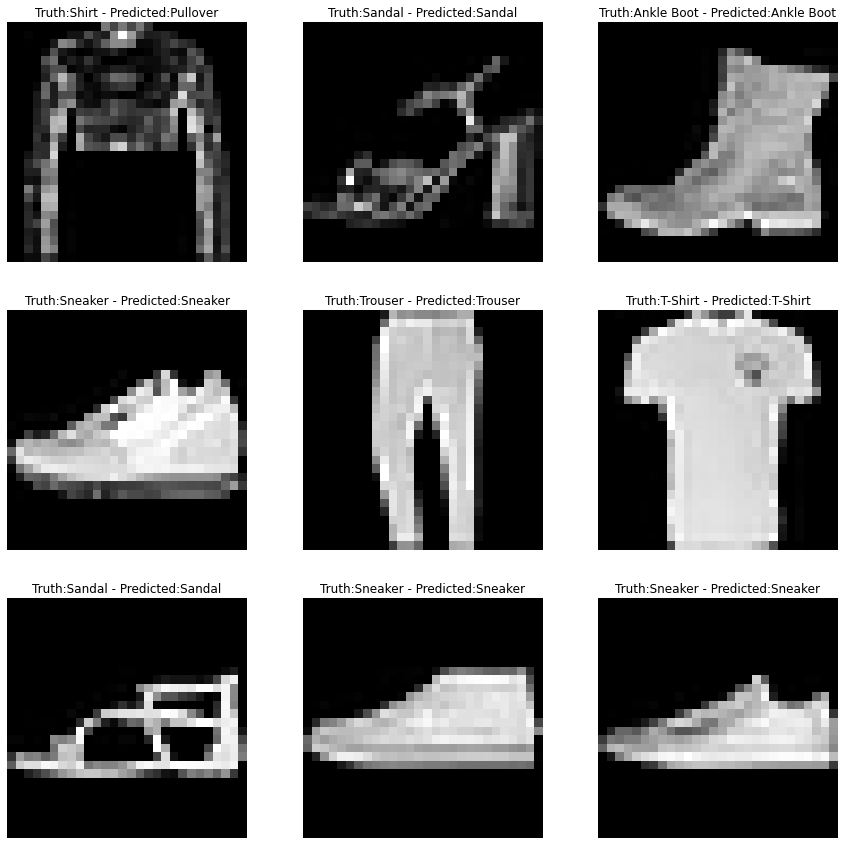

In [25]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

L = len(params) // 2


figure = plt.figure(figsize=(15, 15))
cols, rows = 3, 3
counter =1

for i in range(9):
    sample_idx = np.random.randint(0,test.shape[1])
    
    img, label = np.array([test[:,sample_idx]]).reshape(784,1),test_labels[sample_idx]
    #print(img)
    activations = forward_prop(img, params)
    Y_hat = get_predictions(activations['A4'])[0]
    #print(Y_hat)
    #print(label)
    figure.add_subplot(rows, cols, counter)
    plt.title(('Truth:'+str(labels_map[label])+" - Predicted:"+str(labels_map[Y_hat])))
    plt.axis("off")
    plt.imshow(img.reshape(28,28).squeeze(), cmap="gray")
    labels.append(label)
    counter +=1
plt.show()